# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa19.github.io/assignments2019/assignment1) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [ ]:
### IF YOU ARE USING COLAB, UNCOMMENT AND RUN THIS BLOCK FIRST ###

# # Mount google drive to allow access to your files
from google.colab import drive
drive.mount('/content/drive')
drive_folder = '/content/drive/MyDrive'
# # Ajust this line to be the assignment1 folder in your google drive
notebook_folder = drive_folder + '/cs682/assignment1'
%cd {notebook_folder}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/cs682/assignment1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd ./cs682/datasets
!bash get_datasets.sh
%cd ../../

/content/drive/MyDrive/cs682/assignment1/cs682/datasets
--2023-09-30 13:55:09--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  43.7MB/s    in 4.1s    

2023-09-30 13:55:13 (39.2 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content/drive/MyDrive/cs682/assignment1


In [ ]:
# Run some setup code for this notebook.
from __future__ import print_function

import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs682/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Don't forget to run get_datasets.sh, or this will throw an error
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


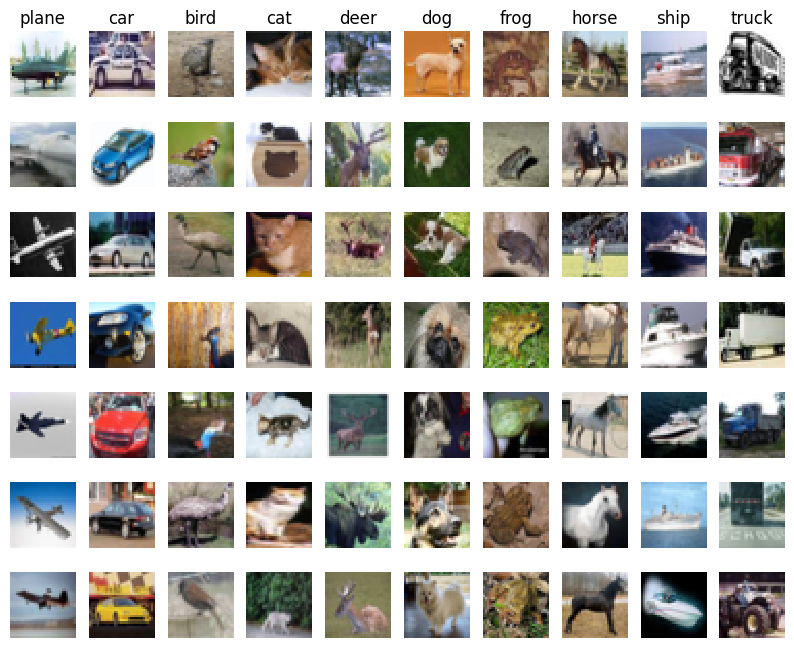

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [ ]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [ ]:
from cs682.classifiers import KNearestNeighbor

# Create a kNN classifier instance.
# Remember that training a kNN classifier is a noop:
# the Classifier simply remembers the data and does no further processing
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

1. First we must compute the distances between all test examples and all train examples.
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs682/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [ ]:
# Open cs682/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


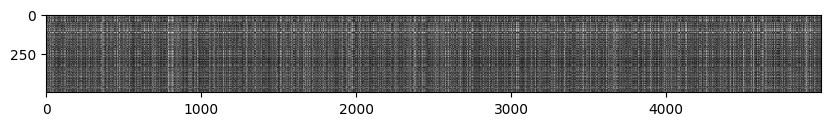

In [ ]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**:


*   Distinctly bright rows indicate that the test data point is very far from the training data points, which means they differ significantly from the images in the training set. These can be considered as outliers in test data.
*   Distinctly bright columns indicate that the training set image is very different from the test images and doesn’t affect its classification, these can be considered as outliers in training data.



In [ ]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [ ]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 145 / 500 correct => accuracy: 0.290000


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**
We can also other distance metrics such as L1 distance.
The performance of a Nearest Neighbor classifier that uses L1 distance will not change if (Select all that apply.):
1. The data is preprocessed by subtracting the mean.
2. The data is preprocessed by subtracting the mean and dividing by the standard deviation.
3. The coordinate axes for the data are rotated.
4. None of the above.
(Mean and standard deviation in (1) and (2) are vectors and can be different across dimensions)
*Your Answer*: 1 & 2


*Your explanation*:

In case 1, subtracting the mean from the data only shifts the data points and doesn’t change their relative distances.

In case 2, it changes the scale of the data and doesn't change the relative distances between data points.

In case 3, rotating the coordinate axes for the data changes the L1 distances between data points unequally as it is sensitive to the orientation. Hence, the performance will change.

In [ ]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [ ]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [ ]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 22.311193 seconds
One loop version took 32.675360 seconds
No loop version took 0.601939 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for k in k_choices:
  k_to_accuracies[k] = []
  for n in range(num_folds):
    X_train_cv = np.concatenate([X_train_folds[i] for i in range(num_folds) if i != n])
    y_train_cv = np.concatenate([y_train_folds[i] for i in range(num_folds) if i != n])
    X_test_cv = X_train_folds[n]
    y_test_cv = y_train_folds[n]
    classifier = KNearestNeighbor()
    classifier.train(X_train_cv,y_train_cv)
    dists = classifier.compute_distances_no_loops(X_test_cv)
    y_pred_cv = classifier.predict(X_test_cv,k)
    num_correct = np.sum(y_pred_cv == y_test_cv)
    accuracy = float(num_correct)/len(y_pred_cv)
    k_to_accuracies[k].append(accuracy)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.257000
k = 3, accuracy = 0.263000
k = 3, accuracy = 0.273000
k = 3, accuracy = 0.282000
k = 3, accuracy = 0.270000
k = 5, accuracy = 0.265000
k = 5, accuracy = 0.275000
k = 5, accuracy = 0.295000
k = 5, accuracy = 0.298000
k = 5, accuracy = 0.284000
k = 8, accuracy = 0.272000
k = 8, accuracy = 0.295000
k = 8, accuracy = 0.284000
k = 8, accuracy = 0.298000
k = 8, accuracy = 0.290000
k = 10, accuracy = 0.272000
k = 10, accuracy = 0.303000
k = 10, accuracy = 0.289000
k = 10, accuracy = 0.292000
k = 10, accuracy = 0.285000
k = 12, accuracy = 0.271000
k = 12, accuracy = 0.305000
k = 12, accuracy = 0.285000
k = 12, accuracy = 0.289000
k = 12, accuracy = 0.281000
k = 15, accuracy = 0.260000
k = 15, accuracy = 0.302000
k = 15, accuracy = 0.292000
k = 15, accuracy = 0.292000
k = 15, accuracy = 0.285000
k = 20, accuracy = 0.268000
k = 20, accu

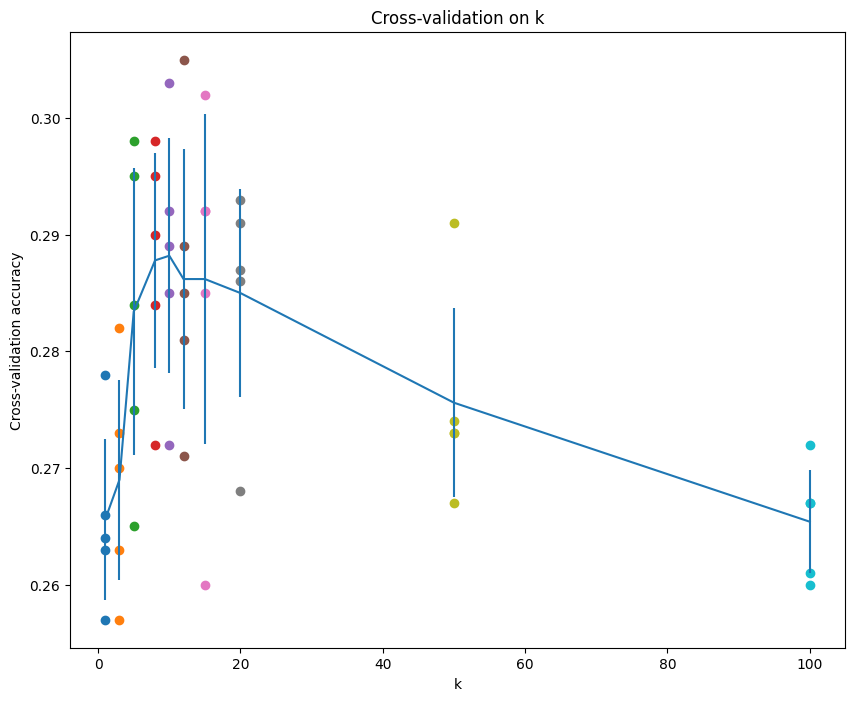

In [ ]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# Based on the cross-validation results above, choose the best value for k,
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 144 / 500 correct => accuracy: 0.288000


**Inline Question 3**
Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The training error of a 1-NN will always be better than or equal to that of 5-NN.
2. The test error of a 1-NN will always be better than that of a 5-NN.
3. The decision boundary of the k-NN classifier is linear.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

*Your Answer*: 1 & 4

*Your explanation*:

In a 1-NN classifier, the training error is always zero because it matches each training point with itself whereas 5-NN classifier can have a higher training error since it looks at the labels of the five nearest neighbors, which might differ from the point itself. 1 - TRUE

The test error comparison between 1-NN and 5-NN depends on data characteristics; 1-NN isn't always better, as it can be sensitive to noise and outliers. A 5-NN classifier may offer more stable predictions. 2 - FALSE

The decision boundary of a k-NN classifier is not necessarily linear. It can be complex and non-linear, as it depends on the distribution and arrangement of the training data points. 3 - FALSE

The time complexity of k-NN classification grows with the size of the training set because it involves calculating distances between the test data point and all training data points. 4 - TRUE

# **Decision Boundaries with PCA - KNN**

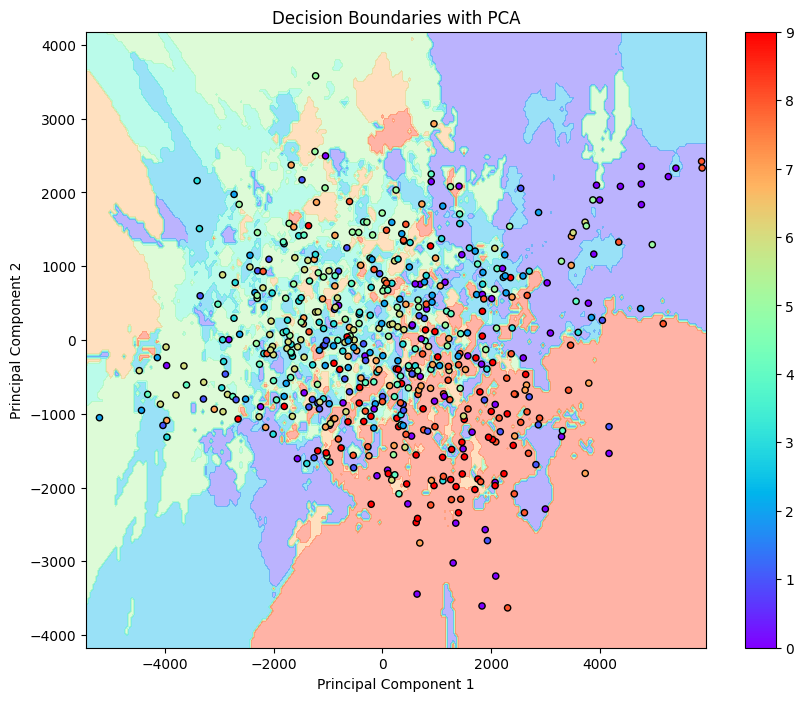

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train the k-Nearest Neighbor classifier on the reduced-dimension training data
classifier = KNearestNeighbor()
classifier.train(X_train_pca, y_train)

# Create a grid of points in 2D space
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 50),
                     np.arange(y_min, y_max, 50))

# Predict the labels for each point in the grid
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()],k=best_k)
Z = Z.reshape(xx.shape)

# Define a colormap for 10 classes
colors = plt.cm.rainbow(np.linspace(0, 1, 10))

# Plot the decision boundaries with 10 different colors
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.rainbow)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, s=20, edgecolor='k', cmap=plt.cm.rainbow)
plt.title('Decision Boundaries with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add a colorbar for class labels
colorbar = plt.colorbar()
colorbar.set_ticks(np.arange(0, 10))
colorbar.set_ticklabels(np.arange(0, 10))

plt.show()

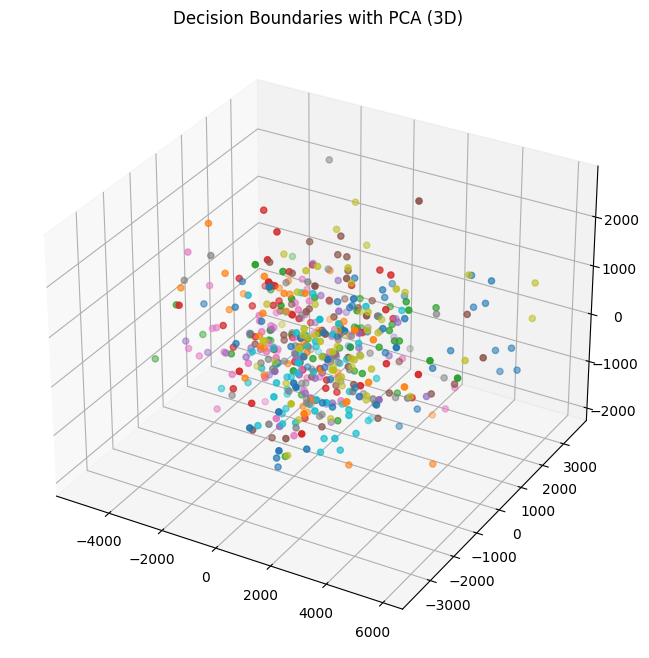

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# PCA to reduce dimensionality to 3D
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train the k-Nearest Neighbor classifier on the reduced-dimension training data
classifier = KNearestNeighbor()
classifier.train(X_train_pca, y_train)

# Create a grid of points in 3D space
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
z_min, z_max = X_train_pca[:, 2].min() - 1, X_train_pca[:, 2].max() + 1
xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, 500),
                         np.arange(y_min, y_max, 500),
                         np.arange(z_min, z_max, 500))

# Predict the labels for each point in the 3D grid
points_3d = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
Z = classifier.predict(points_3d,k=best_k)
Z = Z.reshape(xx.shape)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for label in np.unique(y_test):
    mask = (y_test == label)
    ax.scatter(X_test_pca[mask, 0], X_test_pca[mask, 1], X_test_pca[mask, 2], label=f'Class {label}', s=20)

ax.set_title('Decision Boundaries with PCA (3D)')

classes = np.unique(y_test)
colorbar.set_ticklabels(classes)

plt.show()